#### CANB8347 Machine Learning Project
Given annotated dataset, develop a supervised machine learning method to predict live births from multi-dimensional data  
##### 1) Imputation

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

# sklearn tools
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline

In [2]:
# read the 'numerified' data from .csv file
vlbw = pd.read_csv('data/vlbw_train_numeric.csv')
# ensure expected number of observations and features
vlbw.shape

(513, 32)

In [3]:
# look at features with missing observations
vlbw.isnull().sum()[vlbw.isnull().sum()>0]

birth         1
exit          8
hospstay      8
lowph        30
pltct        37
gest          1
lol         160
apg1         10
vent          6
pneumo        2
pda           4
cld          38
pvh         107
ivh         106
ipe         106
year          1
dtype: int64

We want to replace `NaN` values with the median in their column for all features _except the following_:
* `lol`: mean/median value of vaginal births
* `pvh`, `ivh`, & `ipe`: use random forest classifier to impute

In [4]:
# insert median lol for vaginal births into missing values
lol_val = np.nanmedian(vlbw[vlbw.delivery_vaginal==1]['lol'])
vlbw.loc[vlbw.lol.isnull(), 'lol'] = lol_val

In [5]:
# replace missing values with the median of the other values
vlbw.fillna(value={'birth':np.nanmedian(vlbw.birth),'exit':np.nanmedian(vlbw.exit),'hospstay':np.nanmedian(vlbw.hospstay),'lowph':np.nanmedian(vlbw.lowph),
                  'pltct':np.nanmedian(vlbw.pltct),'gest':np.nanmedian(vlbw.gest),'apg1':np.nanmedian(vlbw.apg1),'vent':np.nanmedian(vlbw.vent),
                  'pneumo':np.nanmedian(vlbw.pneumo),'pda':np.nanmedian(vlbw.pda),'cld':np.nanmedian(vlbw.cld),'year':np.nanmedian(vlbw.year)}, inplace=True)

In [6]:
# look at remaining features with missing observations
vlbw.isnull().sum()[vlbw.isnull().sum()>0]

pvh    107
ivh    106
ipe    106
dtype: int64

---
Now feed the rows with known `ivh`, `pvh`, and `ipe` values into a random forest classifier to impute the unknowns

In [7]:
# ignore the columns we're trying to impute
vlbw_imputetrainer = vlbw.drop(['ivh','pvh','ipe'], axis=1)

In [8]:
# starting with pvh, make training set the obs with pvh and predicting set the obs w/o pvh values
fit = vlbw_imputetrainer[-vlbw.pvh.isnull() & -vlbw.pvh.isnull() & -vlbw.pvh.isnull()]
predict = vlbw_imputetrainer[vlbw.pvh.isnull() & vlbw.pvh.isnull() & vlbw.pvh.isnull()]

In [9]:
# get labels of training set
fit_labels = vlbw.loc[-vlbw.pvh.isnull() & -vlbw.pvh.isnull() & -vlbw.pvh.isnull(), 'pvh']

In [10]:
# normalize each column to fractional representation between 0 and 1
fit_norm = normalize(fit, axis=1, norm='l1')

In [11]:
# random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(fit_norm, fit_labels)
clf.score(fit_norm, fit_labels)

0.9137931034482759

In [12]:
predict_norm = normalize(predict, axis=1, norm='l1')

In [13]:
pvh_prediction = clf.predict(predict_norm)

---

In [14]:
# now ivh, make training set the obs with ivh and predicting set the obs w/o ivh values
fit = vlbw_imputetrainer[-vlbw.ivh.isnull() & -vlbw.ivh.isnull() & -vlbw.ivh.isnull()]
predict = vlbw_imputetrainer[vlbw.ivh.isnull() & vlbw.ivh.isnull() & vlbw.ivh.isnull()]

In [15]:
# get labels of training set
fit_labels = vlbw.loc[-vlbw.ivh.isnull() & -vlbw.ivh.isnull() & -vlbw.ivh.isnull(), 'ivh']

In [16]:
# normalize each column to fractional representation between 0 and 1
fit_norm = normalize(fit, axis=1, norm='l1')

In [17]:
# random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(fit_norm, fit_labels)
clf.score(fit_norm, fit_labels)

0.9828009828009828

In [18]:
predict_norm = normalize(predict, axis=1, norm='l1')

In [19]:
ivh_prediction = clf.predict(predict_norm)

---

In [20]:
# now ipe, make training set the obs with ipe and predicting set the obs w/o ipe values
fit = vlbw_imputetrainer[-vlbw.ipe.isnull() & -vlbw.ipe.isnull() & -vlbw.ipe.isnull()]
predict = vlbw_imputetrainer[vlbw.ipe.isnull() & vlbw.ipe.isnull() & vlbw.ipe.isnull()]

In [21]:
# get labels of training set
fit_labels = vlbw.loc[-vlbw.ipe.isnull() & -vlbw.ipe.isnull() & -vlbw.ipe.isnull(), 'ipe']

In [22]:
# normalize each column to fractional representation between 0 and 1
fit_norm = normalize(fit, axis=1, norm='l1')

In [23]:
# random forest classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(fit_norm, fit_labels)
clf.score(fit_norm, fit_labels)

0.9705159705159705

In [24]:
predict_norm = normalize(predict, axis=1, norm='l1')

In [25]:
ipe_prediction = clf.predict(predict_norm)

---
Add predictions back to original dataframe and we should have a completely imputed training set

In [26]:
vlbw.loc[vlbw.pvh.isnull(), 'pvh'] = pvh_prediction
vlbw.loc[vlbw.ivh.isnull(), 'ivh'] = ivh_prediction
vlbw.loc[vlbw.ipe.isnull(), 'ipe'] = ipe_prediction

In [28]:
# make sure we don't have any more empty values
vlbw.isnull().sum()[vlbw.isnull().sum()>0]

Series([], dtype: int64)

Bingo.  Now perform PCA to evaluate variability in resulting dataset.

---
#### Look at principal components and see where highest explained variance lies

In [29]:
# normalize each column to fractional representation between 0 and 1
vlbw_norm = normalize(vlbw, axis=1, norm='l1')

In [32]:
# perform principal component analysis on entire imputed dataset
vlbw_PCA_fit = PCA(n_components=5).fit(vlbw_norm)
vlbw_PCA = vlbw_PCA_fit.transform(vlbw_norm)

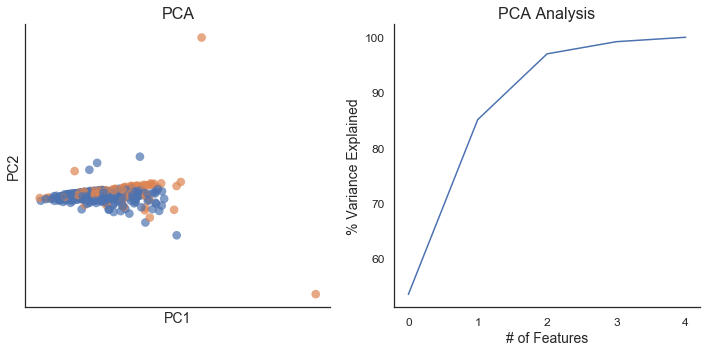

In [33]:
# plot PCA results for first two PCs, colored by desired label (live birth)
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x=vlbw_PCA[:,0], y=vlbw_PCA[:,1], s=75, alpha=0.7, hue=vlbw['dead'], legend=None, edgecolor='none')
plt.tick_params(labelbottom=False, labelleft=False)
plt.ylabel('PC2', fontsize=14)
plt.xlabel('PC1', fontsize=14)
plt.title('PCA', fontsize=16)

plt.subplot(122)
plt.plot(np.cumsum(np.round(vlbw_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.tick_params(labelsize=12)
plt.ylabel('% Variance Explained', fontsize=14)
plt.xlabel('# of Features', fontsize=14)
plt.title('PCA Analysis', fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()

In [34]:
# we can extract the contribution of each feature to each PC
PCfeatures = pd.DataFrame(vlbw_PCA_fit.components_, columns=vlbw.columns)
# look at top 10 features that contribute to PC1, in descending order
PCfeatures.iloc[0,:].rank().sort_values()

bwt                      1.0
apg1                     2.0
delivery_abdominal       3.0
race_white               4.0
twn                      5.0
meth                     6.0
race_native American     7.0
race_oriental            8.0
magsulf                  9.0
toc                     10.0
inout_transported       11.0
pneumo                  12.0
sex_female              13.0
sex_male                14.0
ipe                     15.0
inout_born at Duke      16.0
pda                     17.0
ivh                     18.0
pvh                     19.0
race_black              20.0
delivery_vaginal        21.0
dead                    22.0
cld                     23.0
vent                    24.0
lowph                   25.0
gest                    26.0
lol                     27.0
birth                   28.0
year                    29.0
exit                    30.0
hospstay                31.0
pltct                   32.0
Name: 0, dtype: float64

birth, exit, year, and hospital stay seem pretty useless, and they're at the bottom of PC1 of our PCA in terms of contributed variance.  
Let's throw them out.

In [35]:
vlbw.drop(['birth','exit','hospstay','year'], axis=1, inplace=True)

Now perform PCA again and see how it looks.

In [36]:
# normalize each column to fractional representation between 0 and 1
vlbw_norm = normalize(vlbw, axis=1, norm='l1')

In [37]:
# perform principal component analysis on entire imputed dataset
vlbw_PCA_fit = PCA(n_components=5).fit(vlbw_norm)
vlbw_PCA = vlbw_PCA_fit.transform(vlbw_norm)

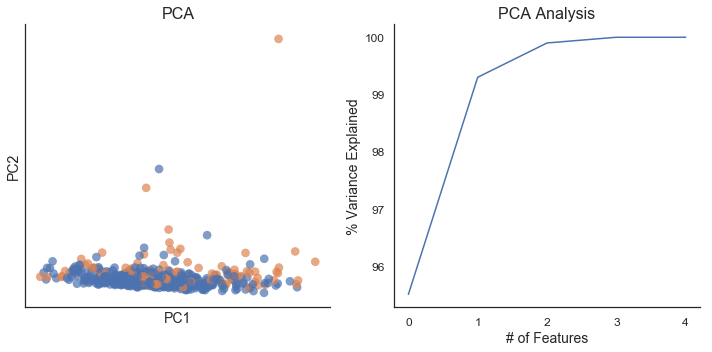

In [38]:
# plot PCA results for first two PCs, colored by desired label (live birth)
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x=vlbw_PCA[:,0], y=vlbw_PCA[:,1], s=75, alpha=0.7, hue=vlbw['dead'], legend=None, edgecolor='none')
plt.tick_params(labelbottom=False, labelleft=False)
plt.ylabel('PC2', fontsize=14)
plt.xlabel('PC1', fontsize=14)
plt.title('PCA', fontsize=16)

plt.subplot(122)
plt.plot(np.cumsum(np.round(vlbw_PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.tick_params(labelsize=12)
plt.ylabel('% Variance Explained', fontsize=14)
plt.xlabel('# of Features', fontsize=14)
plt.title('PCA Analysis', fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()

In [39]:
# save the 'imputed' data as .csv file
vlbw.to_csv('data/vlbw_train_imputed.csv', index=False)

In [48]:
np.argmax(vlbw_PCA[:,1])

342

In [50]:
vlbw.iloc[342,:]

lowph                     7.199997
pltct                   131.000000
bwt                     460.000000
gest                     23.000000
twn                       0.000000
lol                     174.000000
magsulf                   0.000000
meth                      0.000000
toc                       0.000000
apg1                      1.000000
vent                      1.000000
pneumo                    1.000000
pda                       1.000000
cld                       0.000000
pvh                       0.000000
ivh                       2.000000
ipe                       2.000000
dead                      1.000000
race_white                0.000000
race_black                1.000000
race_native American      0.000000
race_oriental             0.000000
inout_born at Duke        1.000000
inout_transported         0.000000
delivery_abdominal        0.000000
delivery_vaginal          1.000000
sex_female                1.000000
sex_male                  0.000000
Name: 342, dtype: fl